In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install nbconvert
# !sudo apt-get install pandoc

In [2]:
# !pip install pennylane

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2022-08-07 22:05:26.896168: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-07 22:05:27.043710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-07 22:05:27.043752: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Setting of the main hyper-parameters of the model
=================================================


In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = len(train_images)    # Size of the train dataset
n_test = len(test_images)     # Size of the test dataset

print(len(train_images))
print(len(test_images))


60000
10000


Loading of the MNIST dataset
============================

We import the MNIST dataset from *Keras*. To speedup the evaluation of
this demo we use only a small number of training and test images.
Obviously, better results are achievable when using the full dataset.


In [18]:

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [19]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [20]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [1]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

In [23]:
# !ls
!pwd

tutorial_quanvolution.ipynb
/mnt/d/Quantum Computing


In [24]:
import os

parent_dir = "/mnt/d/Quantum Computing"
path = os.path.join(parent_dir, SAVE_PATH)
  
os.mkdir(path)

In [25]:
!ls

quanvolution  tutorial_quanvolution.ipynb


In [27]:

if PREPROCESS == True:
    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Let us visualize the effect of the quantum convolution layer on a batch
of samples:


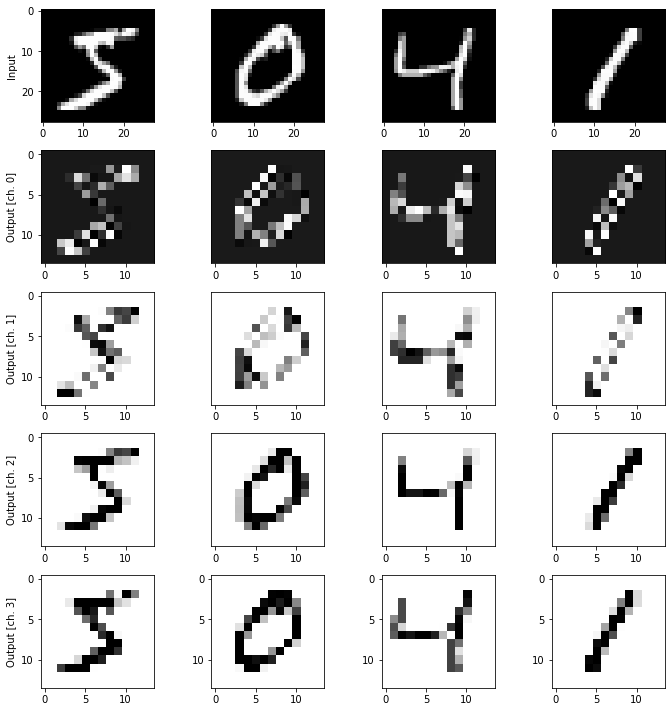

In [28]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


Hybrid quantum-classical model
==============================

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [29]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


In [30]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

2022-07-23 21:38:06.286059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-23 21:38:06.286845: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-23 21:38:06.287670: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BOOK-3T1PPSOGHQ): /proc/driver/nvidia/version does not exist
2022-07-23 21:38:06.295774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
15000/15000 - 36s - loss: 0.3545 - accuracy: 0.8928 - val_loss: 0.2866 - val_accuracy: 0.9153 - 36s/epoch - 2ms/step
Epoch 2/30
15000/15000 - 36s - loss: 0.2528 - accuracy: 0.9252 - val_loss: 0.2371 - val_accuracy: 0.9298 - 36s/epoch - 2ms/step
Epoch 3/30
15000/15000 - 35s - loss: 0.2370 - accuracy: 0.9301 - val_loss: 0.1957 - val_accuracy: 0.9455 - 35s/epoch - 2ms/step
Epoch 4/30
15000/15000 - 35s - loss: 0.2278 - accuracy: 0.9339 - val_loss: 0.2082 - val_accuracy: 0.9414 - 35s/epoch - 2ms/step
Epoch 5/30
15000/15000 - 35s - loss: 0.2212 - accuracy: 0.9364 - val_loss: 0.2234 - val_accuracy: 0.9361 - 35s/epoch - 2ms/step
Epoch 6/30
15000/15000 - 36s - loss: 0.2199 - accuracy: 0.9374 - val_loss: 0.2030 - val_accuracy: 0.9447 - 36s/epoch - 2ms/step
Epoch 7/30
15000/15000 - 30s - loss: 0.2113 - accuracy: 0.9398 - val_loss: 0.3486 - val_accuracy: 0.9098 - 30s/epoch - 2ms/step
Epoch 8/30
15000/15000 - 34s - loss: 0.2129 - accuracy: 0.9394 - val_loss: 0.2442 - val_accuracy: 0.9375

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


In [31]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
15000/15000 - 35s - loss: 0.3599 - accuracy: 0.8996 - val_loss: 0.2850 - val_accuracy: 0.9207 - 35s/epoch - 2ms/step
Epoch 2/30
15000/15000 - 37s - loss: 0.2865 - accuracy: 0.9196 - val_loss: 0.2837 - val_accuracy: 0.9230 - 37s/epoch - 2ms/step
Epoch 3/30
15000/15000 - 34s - loss: 0.2755 - accuracy: 0.9236 - val_loss: 0.2805 - val_accuracy: 0.9229 - 34s/epoch - 2ms/step
Epoch 4/30
15000/15000 - 37s - loss: 0.2703 - accuracy: 0.9247 - val_loss: 0.2795 - val_accuracy: 0.9267 - 37s/epoch - 2ms/step
Epoch 5/30
15000/15000 - 35s - loss: 0.2666 - accuracy: 0.9266 - val_loss: 0.2987 - val_accuracy: 0.9179 - 35s/epoch - 2ms/step
Epoch 6/30
15000/15000 - 36s - loss: 0.2639 - accuracy: 0.9271 - val_loss: 0.2813 - val_accuracy: 0.9261 - 36s/epoch - 2ms/step
Epoch 7/30
15000/15000 - 37s - loss: 0.2612 - accuracy: 0.9286 - val_loss: 0.2818 - val_accuracy: 0.9258 - 37s/epoch - 2ms/step
Epoch 8/30
15000/15000 - 36s - loss: 0.2596 - accuracy: 0.9289 - val_loss: 0.2962 - val_accuracy: 0.9221

Results
=======

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


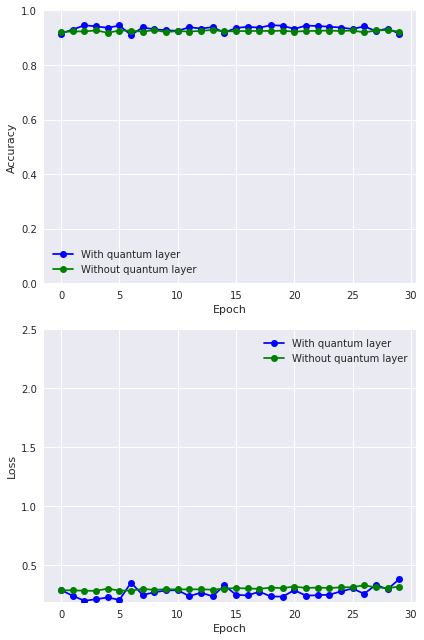

In [32]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

References
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.
